<a href="https://colab.research.google.com/github/ShahedSabab/Fake-or-Not/blob/master/realOrFake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null

In [2]:
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import copy 

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix


from nltk.util import ngrams
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWordList=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [0]:
train= pd.read_csv('data_train.csv')
test=pd.read_csv('data_test.csv')
# save a copy of train
tweet = copy.deepcopy(train) 

Text(0.5, 1.0, 'Number of examples per category')

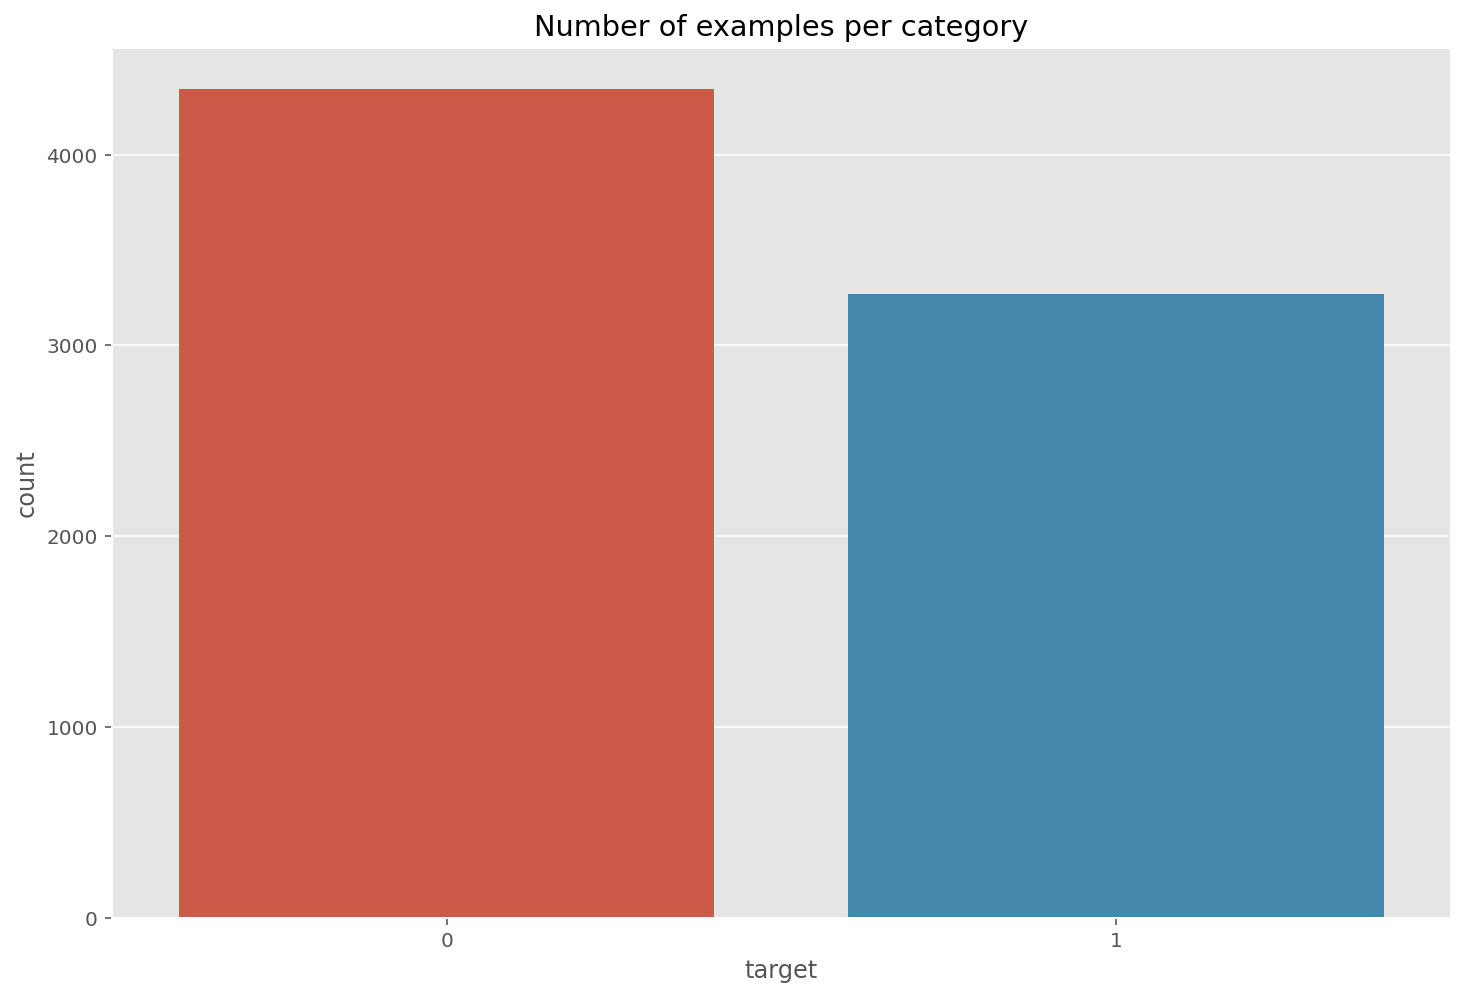

In [5]:
rcParams['figure.figsize'] = 12,8
chart = sns.countplot(train.target)
plt.title("Number of examples per category")

In [6]:
print(f'''Text: {train.iloc[0]['text']}''')
print(f'''Len: {len(train.iloc[0]['text'])}''')

Text: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Len: 69


In [0]:
train['length'] = train['text'].str.split().apply(len)

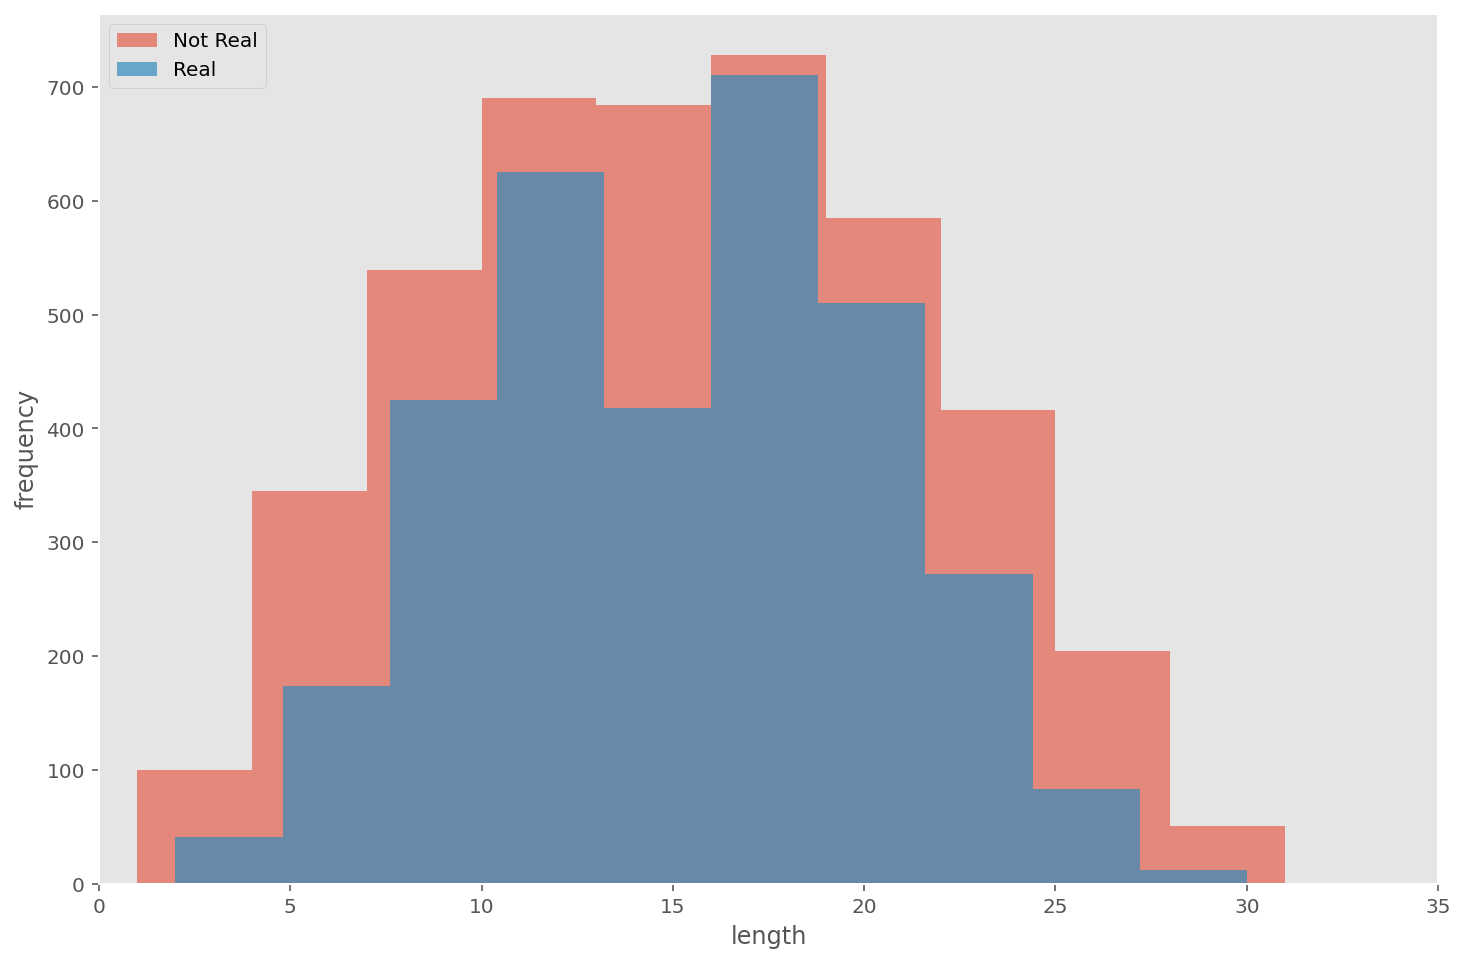

In [8]:
bins = 10
plt.hist(train[train['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not Real')
plt.hist(train[train['target'] == 1]['length'], alpha = 0.7, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('frequency')
plt.legend(loc='upper left')
plt.xlim(0,35)
plt.grid()
plt.show()

# Check common stop words in the tweets

In [0]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Text(0.5, 1.0, 'Top 10 common stop words in fake-disaster tweets')

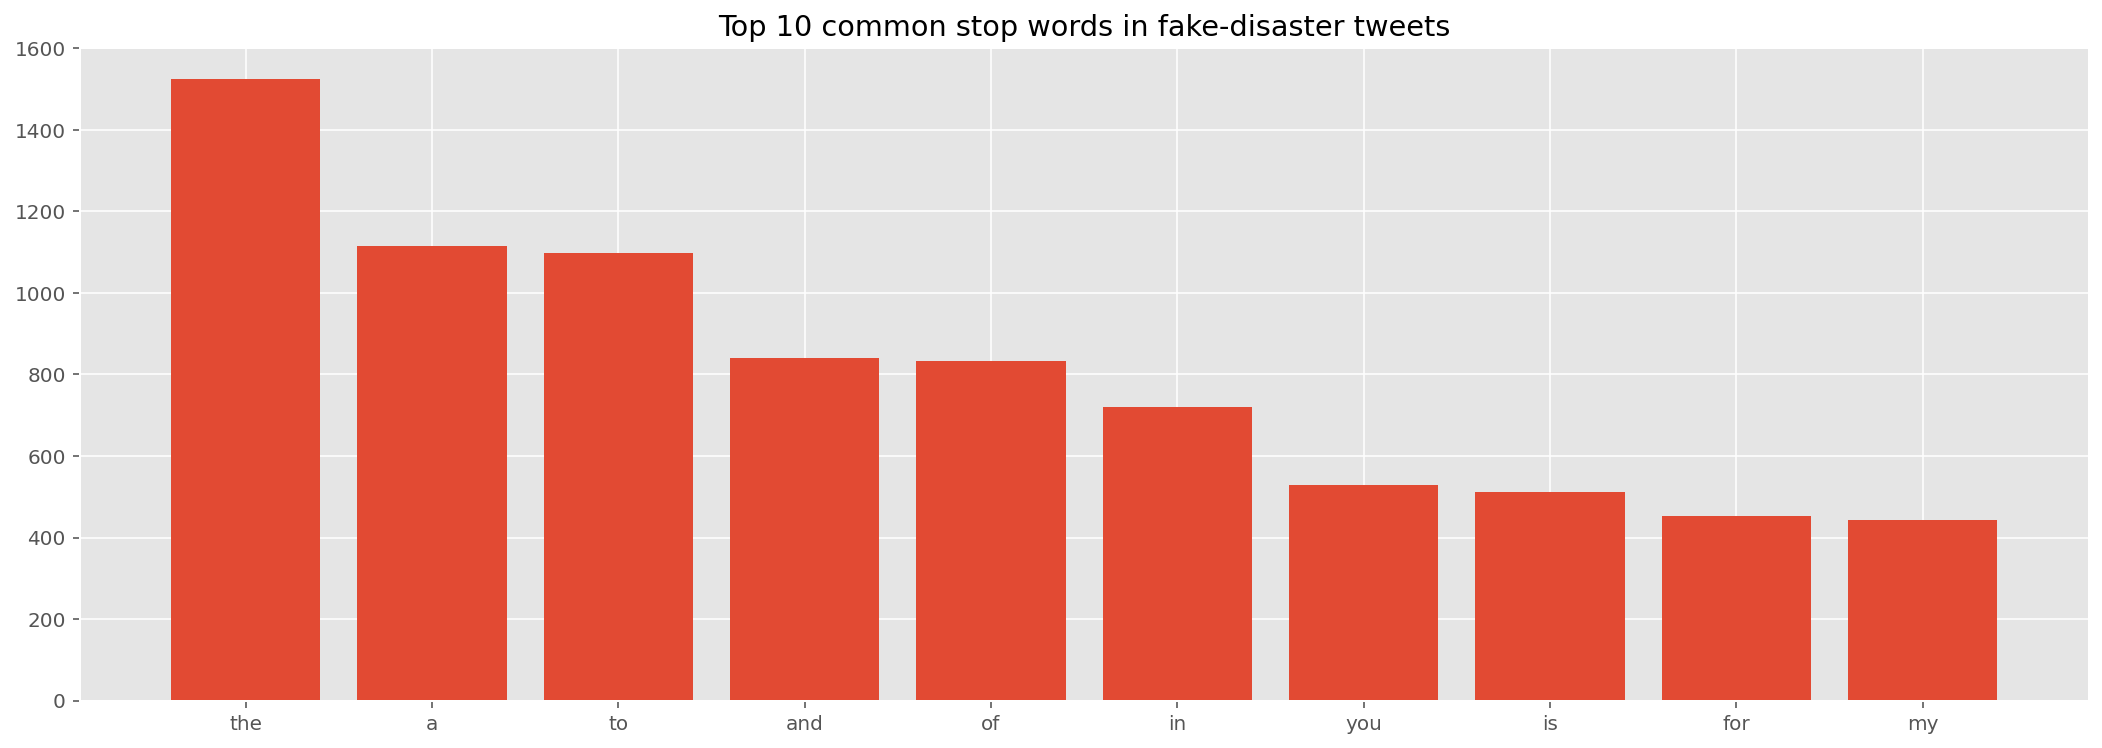

In [10]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stopWordList:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)
plt.title('Top 10 common stop words in fake-disaster tweets')


Text(0.5, 1.0, 'Top 10 common stop words in real-disaster tweets')

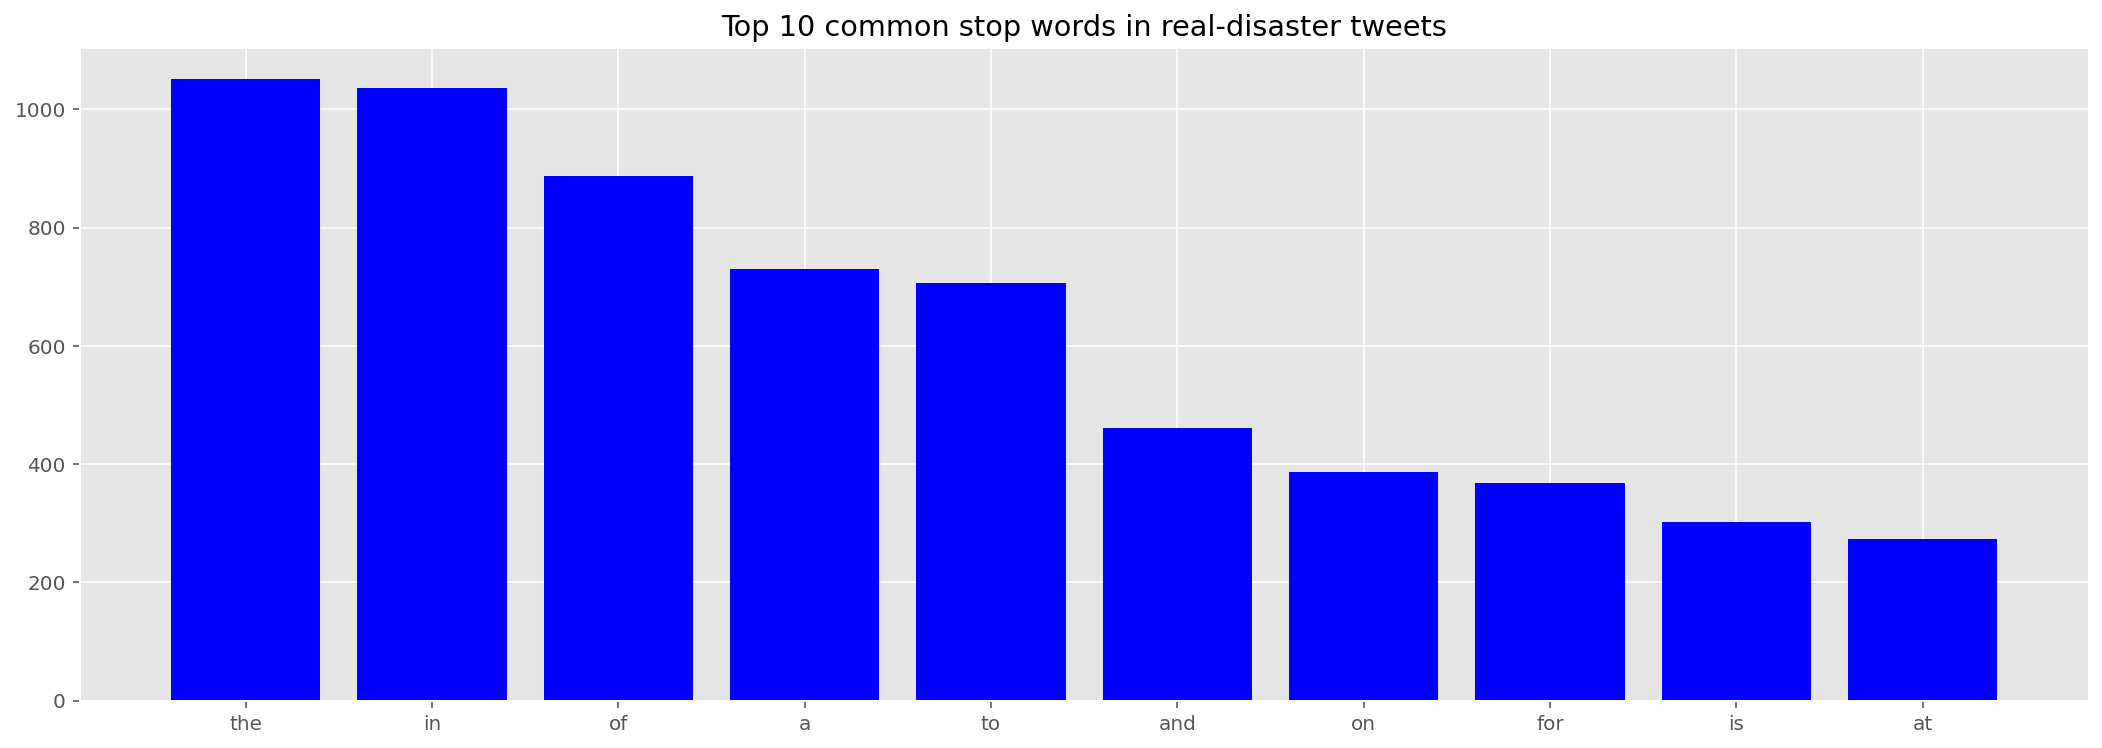

In [11]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stopWordList:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y, color = 'blue')
plt.title('Top 10 common stop words in real-disaster tweets')

# Create N Gram

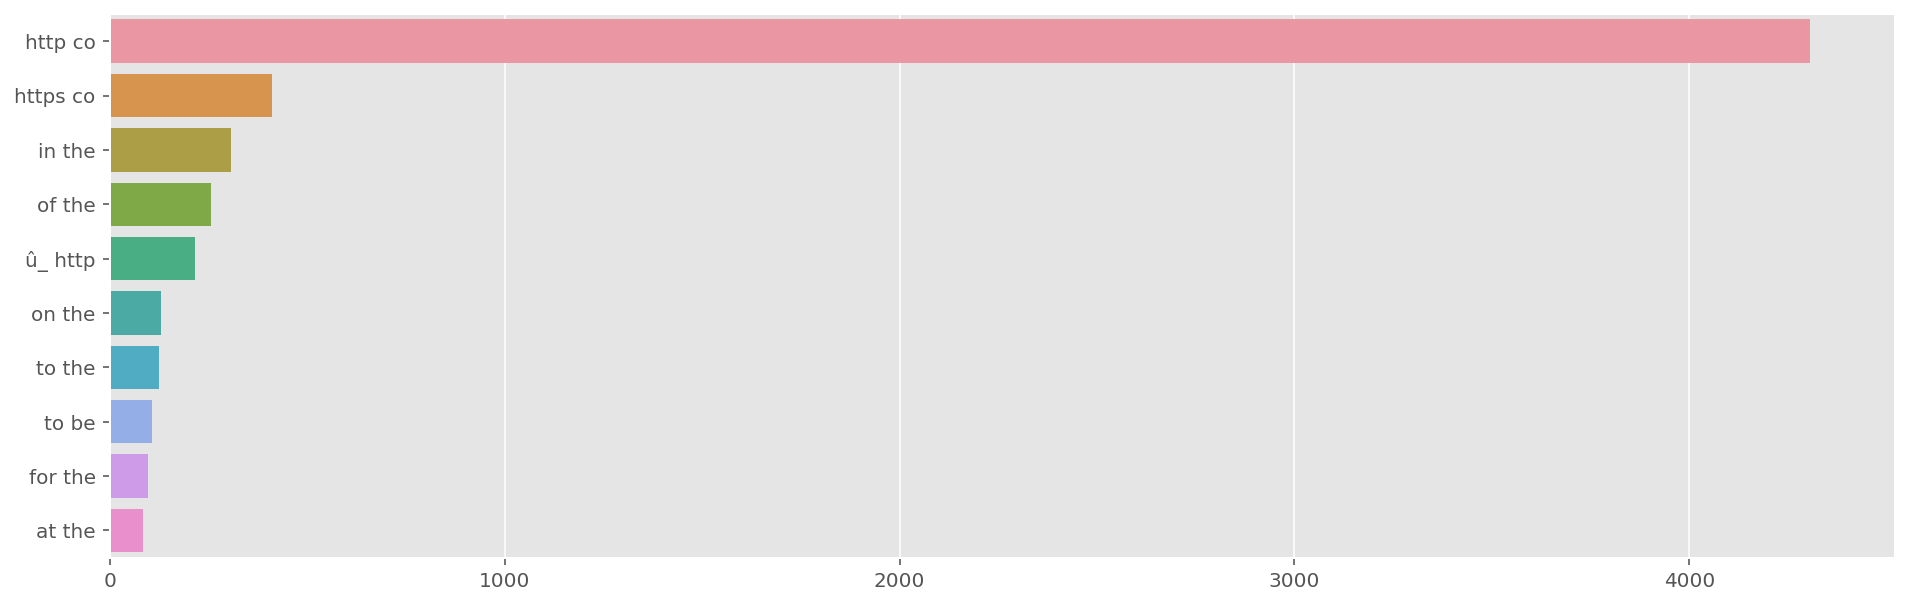

In [12]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

Seemingly, the texts consist some links

# Data Cleaning

In [0]:
df=pd.concat([train,test])

In [0]:
# Remove any part of the URLS from the tweets
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

# Remove HTML Tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

# Remove Punctuation
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

#Remove emoji
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [0]:
# Save data for inspection
df.to_csv('check.csv')
df = df.dropna()

# Train-test split

In [0]:
# train-test split
df = df.reset_index()
text = df["text"].tolist()
labels = df["target"].tolist()
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=RANDOM_SEED)
#copy of the data
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(text, labels, test_size=0.2, random_state=RANDOM_SEED)

# Bag of Words Model

Define important features

In [0]:
# Ref: https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
# plot important words according to the coefficient of Logistic Regression
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5, color = 'red')
    plt.title('Fake Disaster', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5, color = 'blue')
    plt.title('Real Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

Define classification metrics

In [0]:
# Classificaiton metrics - precision, recall, f1, and accuracy
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)


Define the model

In [0]:
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Vislualize the embedded vectors

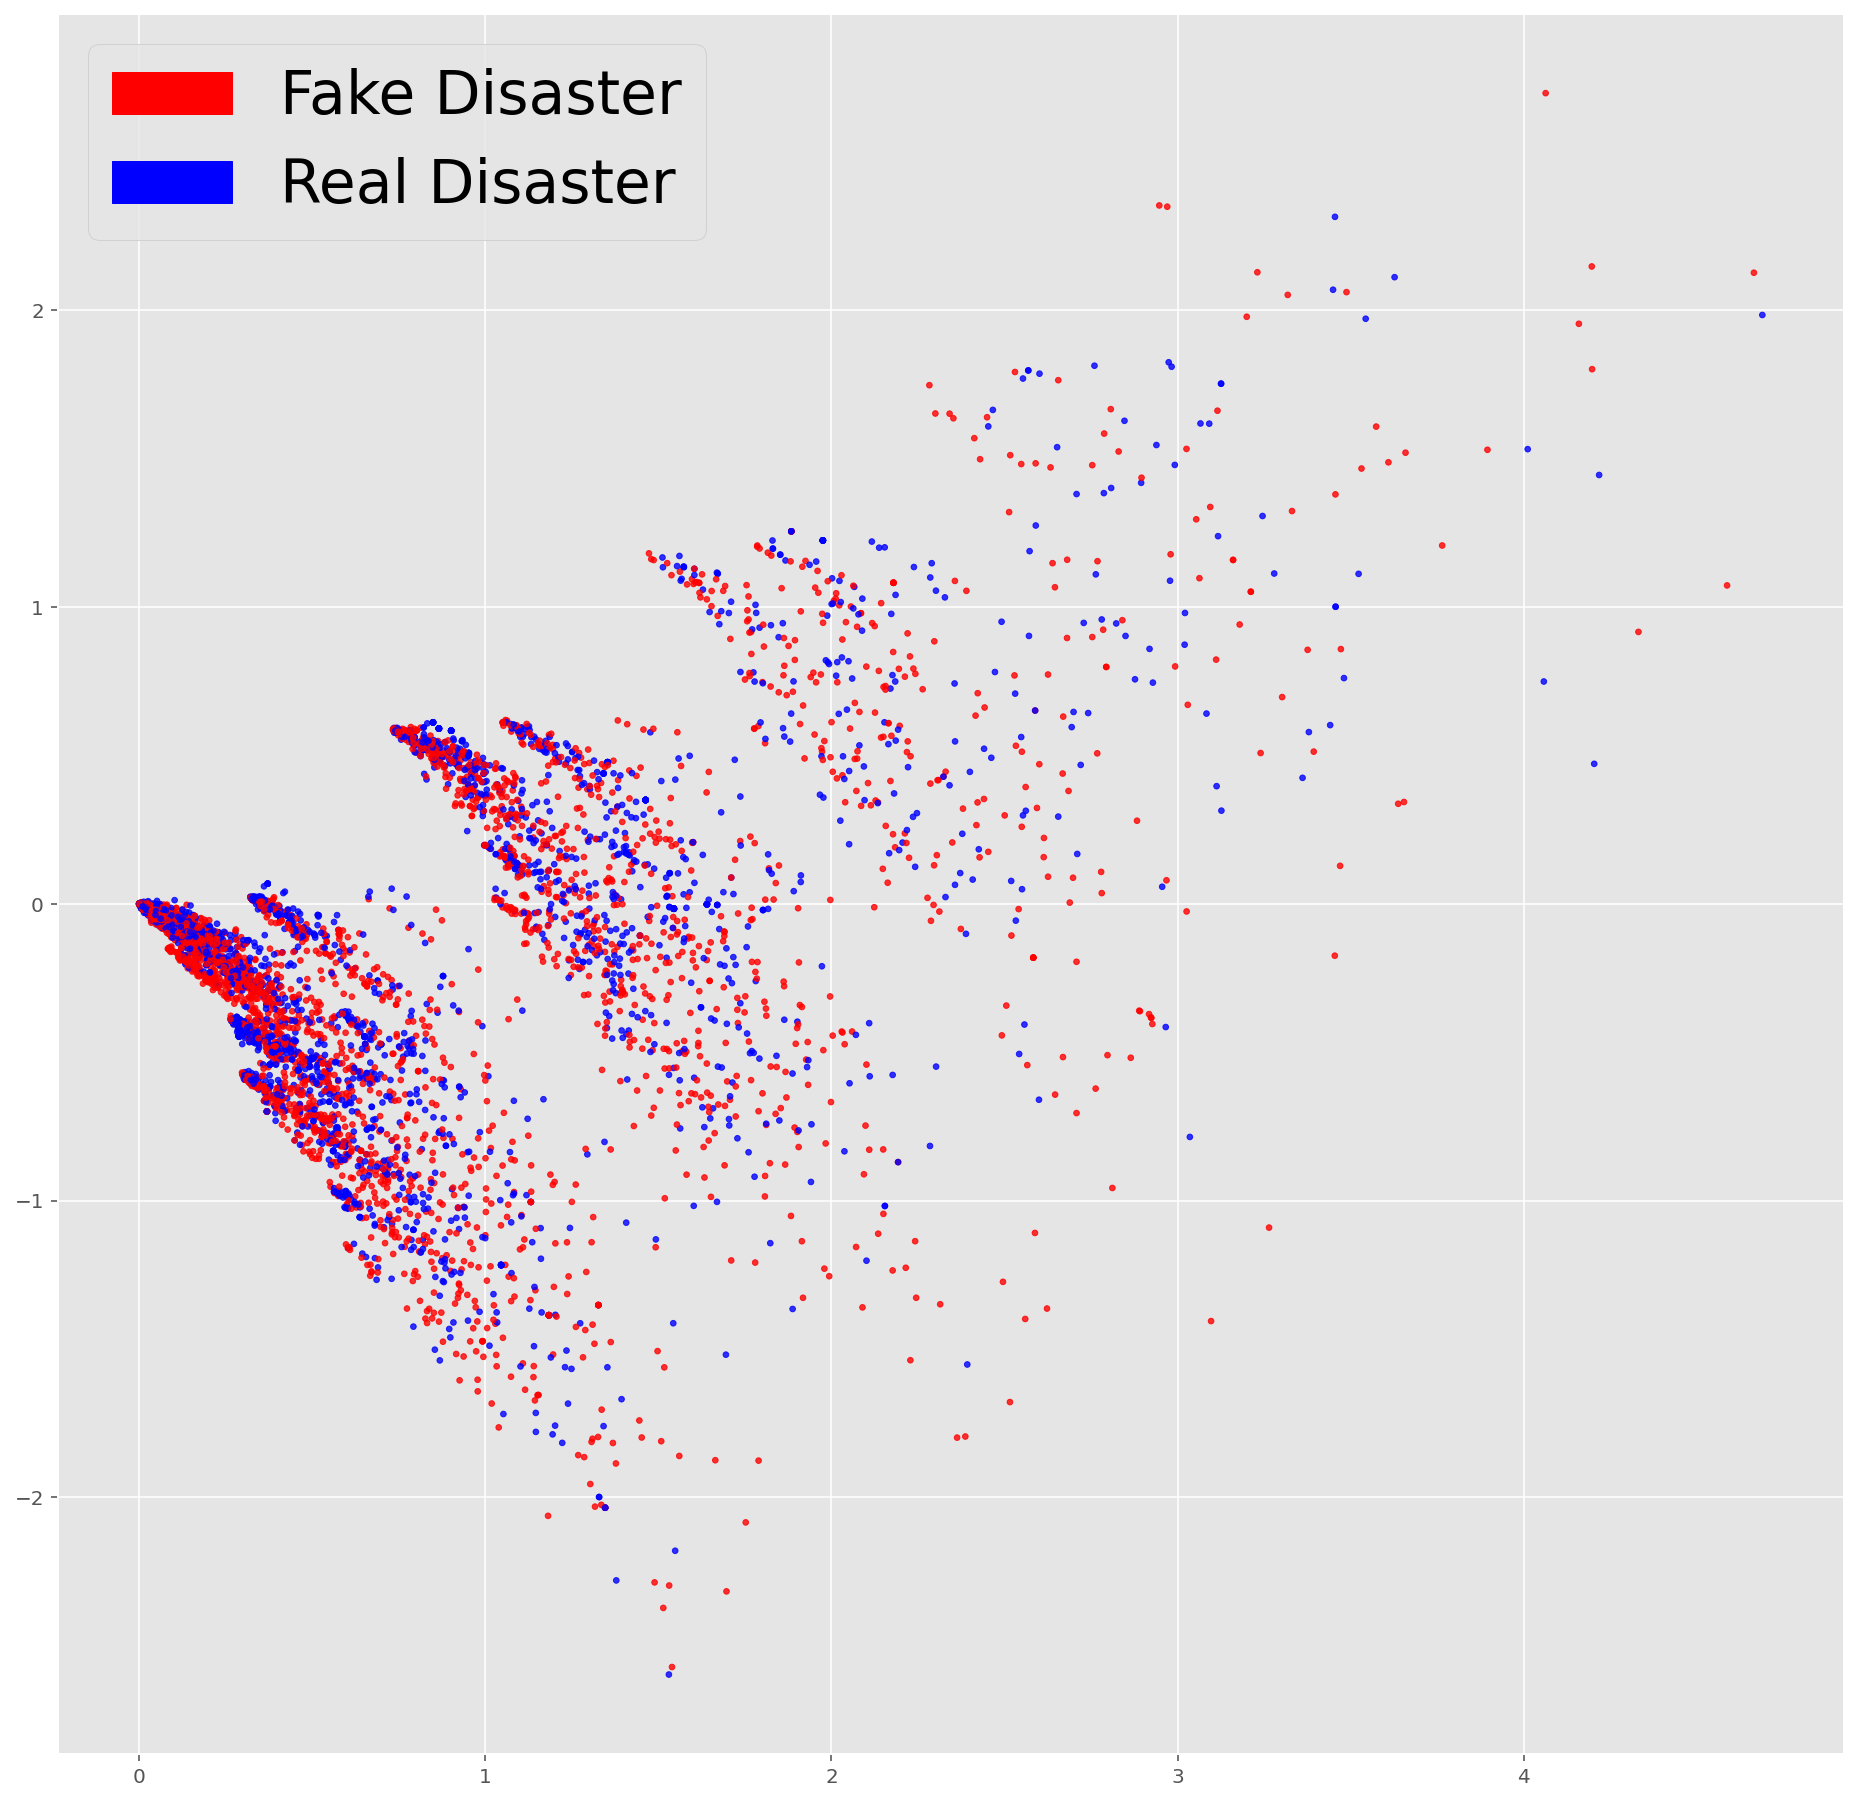

In [20]:
# Ref: https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
# Use LSA - Latent Semantic Analysis to visualize vectors
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
  lsa = TruncatedSVD(n_components=2) # Singular Value Decomposition
  lsa.fit(test_data)
  lsa_scores = lsa.transform(test_data)
  color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
  color_column = [color_mapper[label] for label in test_labels]
  colors = ['red','blue','blue']
  if plot:
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color='red', label='Fake Disaster')
    green_patch = mpatches.Patch(color='blue', label='Real Disaster')
    plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

The features are unlikely to be clearly separable. 

In [21]:
print(X_train[1])
print(X_train_counts[1])

ZachZaidman 670TheScore wld b a shame if that golf cart became engulfed in flames boycottBears
  (0, 506)	1
  (0, 1782)	1
  (0, 2204)	1
  (0, 2657)	1
  (0, 4839)	1
  (0, 5433)	1
  (0, 6030)	1
  (0, 6937)	1
  (0, 7038)	1
  (0, 12235)	1
  (0, 13602)	1
  (0, 15048)	1
  (0, 15357)	1


In [0]:
# Logistic Regression Model
model = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)
train_pred_bow_int = y_pred.round().astype('int')

Evaluation of the BOW model

In [23]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.768, precision = 0.767, recall = 0.768, f1 = 0.767


In [24]:
X_train[1]

'ZachZaidman 670TheScore wld b a shame if that golf cart became engulfed in flames boycottBears'

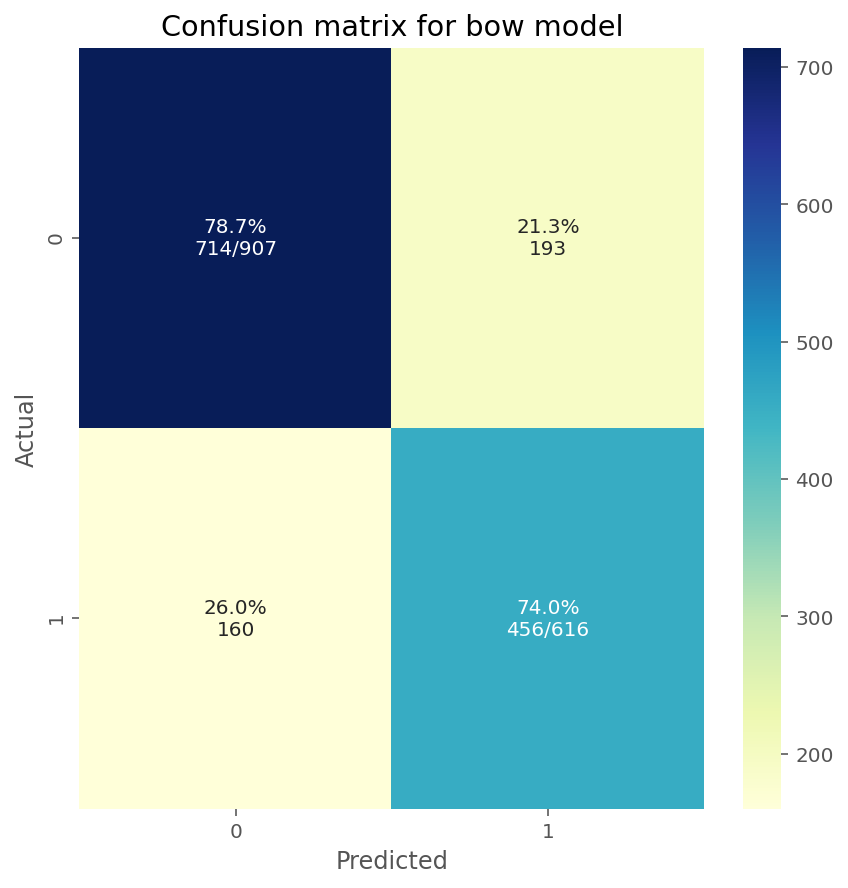

In [25]:
# Showing Confusion Matrix for bow model
plot_cm(train_pred_bow_int, y_test, 'Confusion matrix for bow model', figsize=(7,7))

See important features

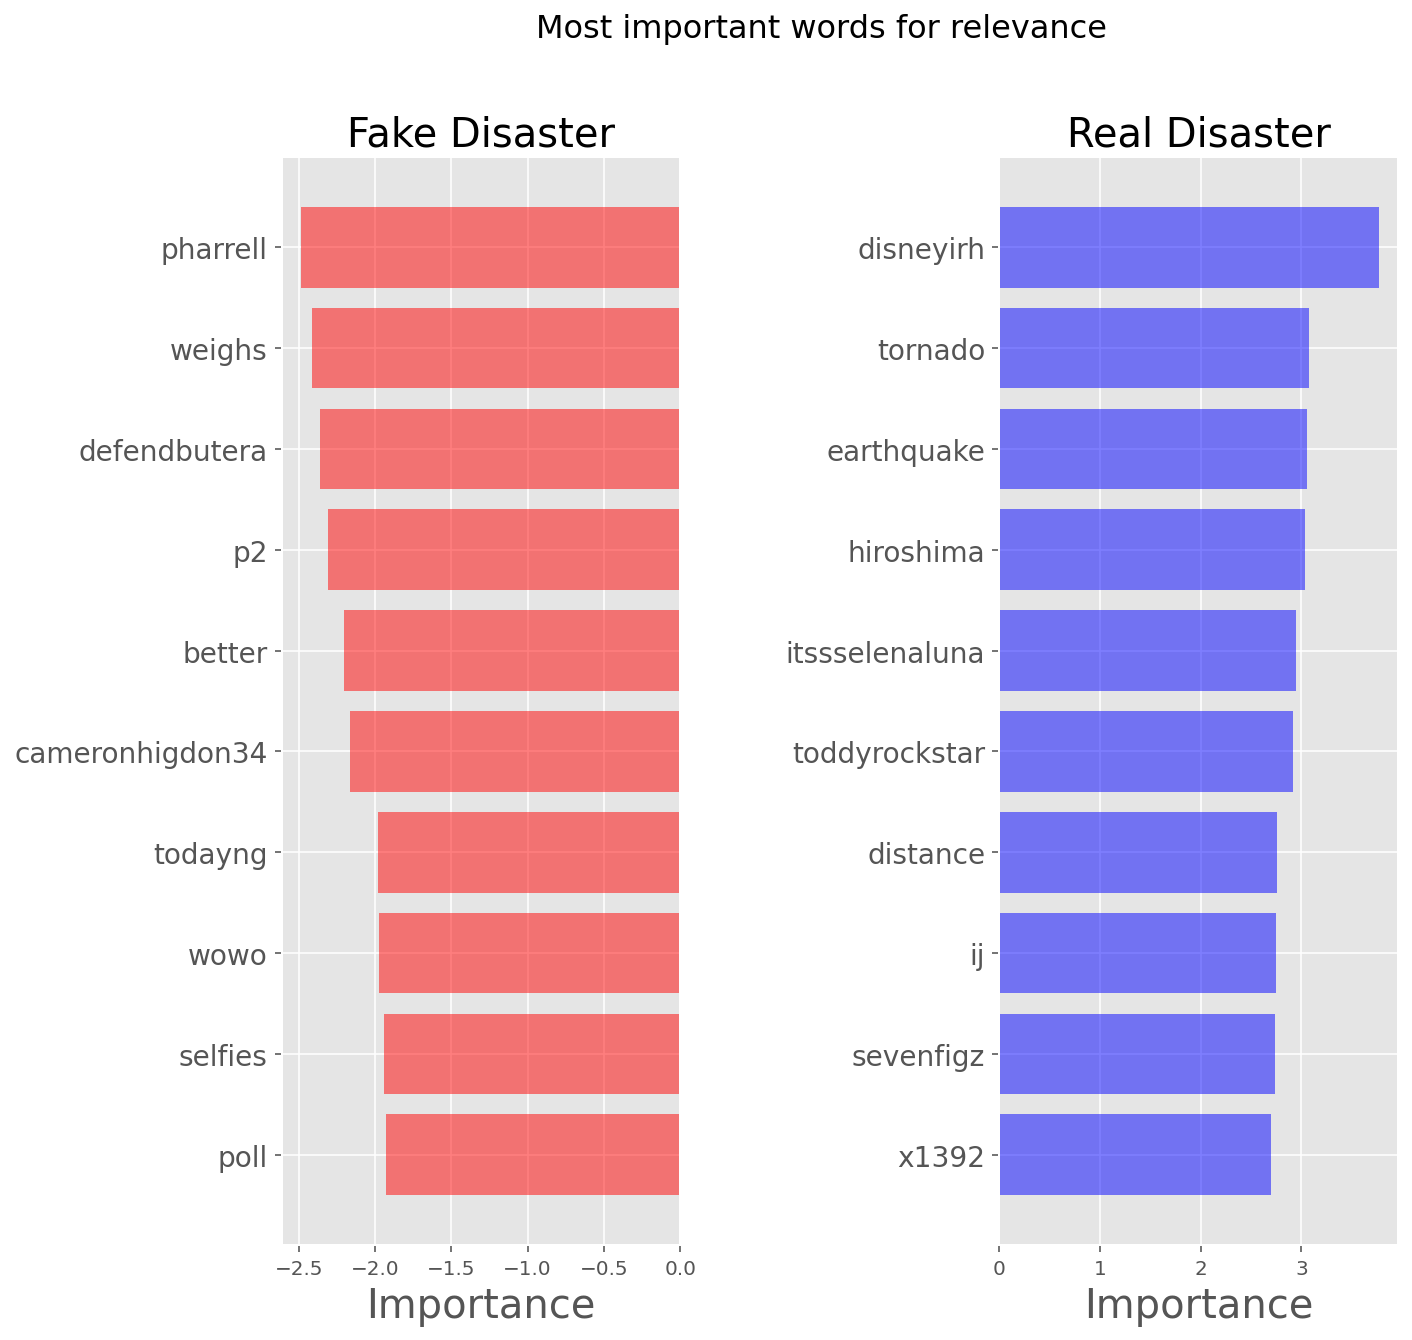

In [26]:
# important words based on the coefficients of Logistic Regression model
importance = get_most_important_features(count_vectorizer, model, 10)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

The top words seem somewhat relevant. Though real-disaster picks upon words such as ij, x1392 are not relevant.

# TF-IDF Model

In [0]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

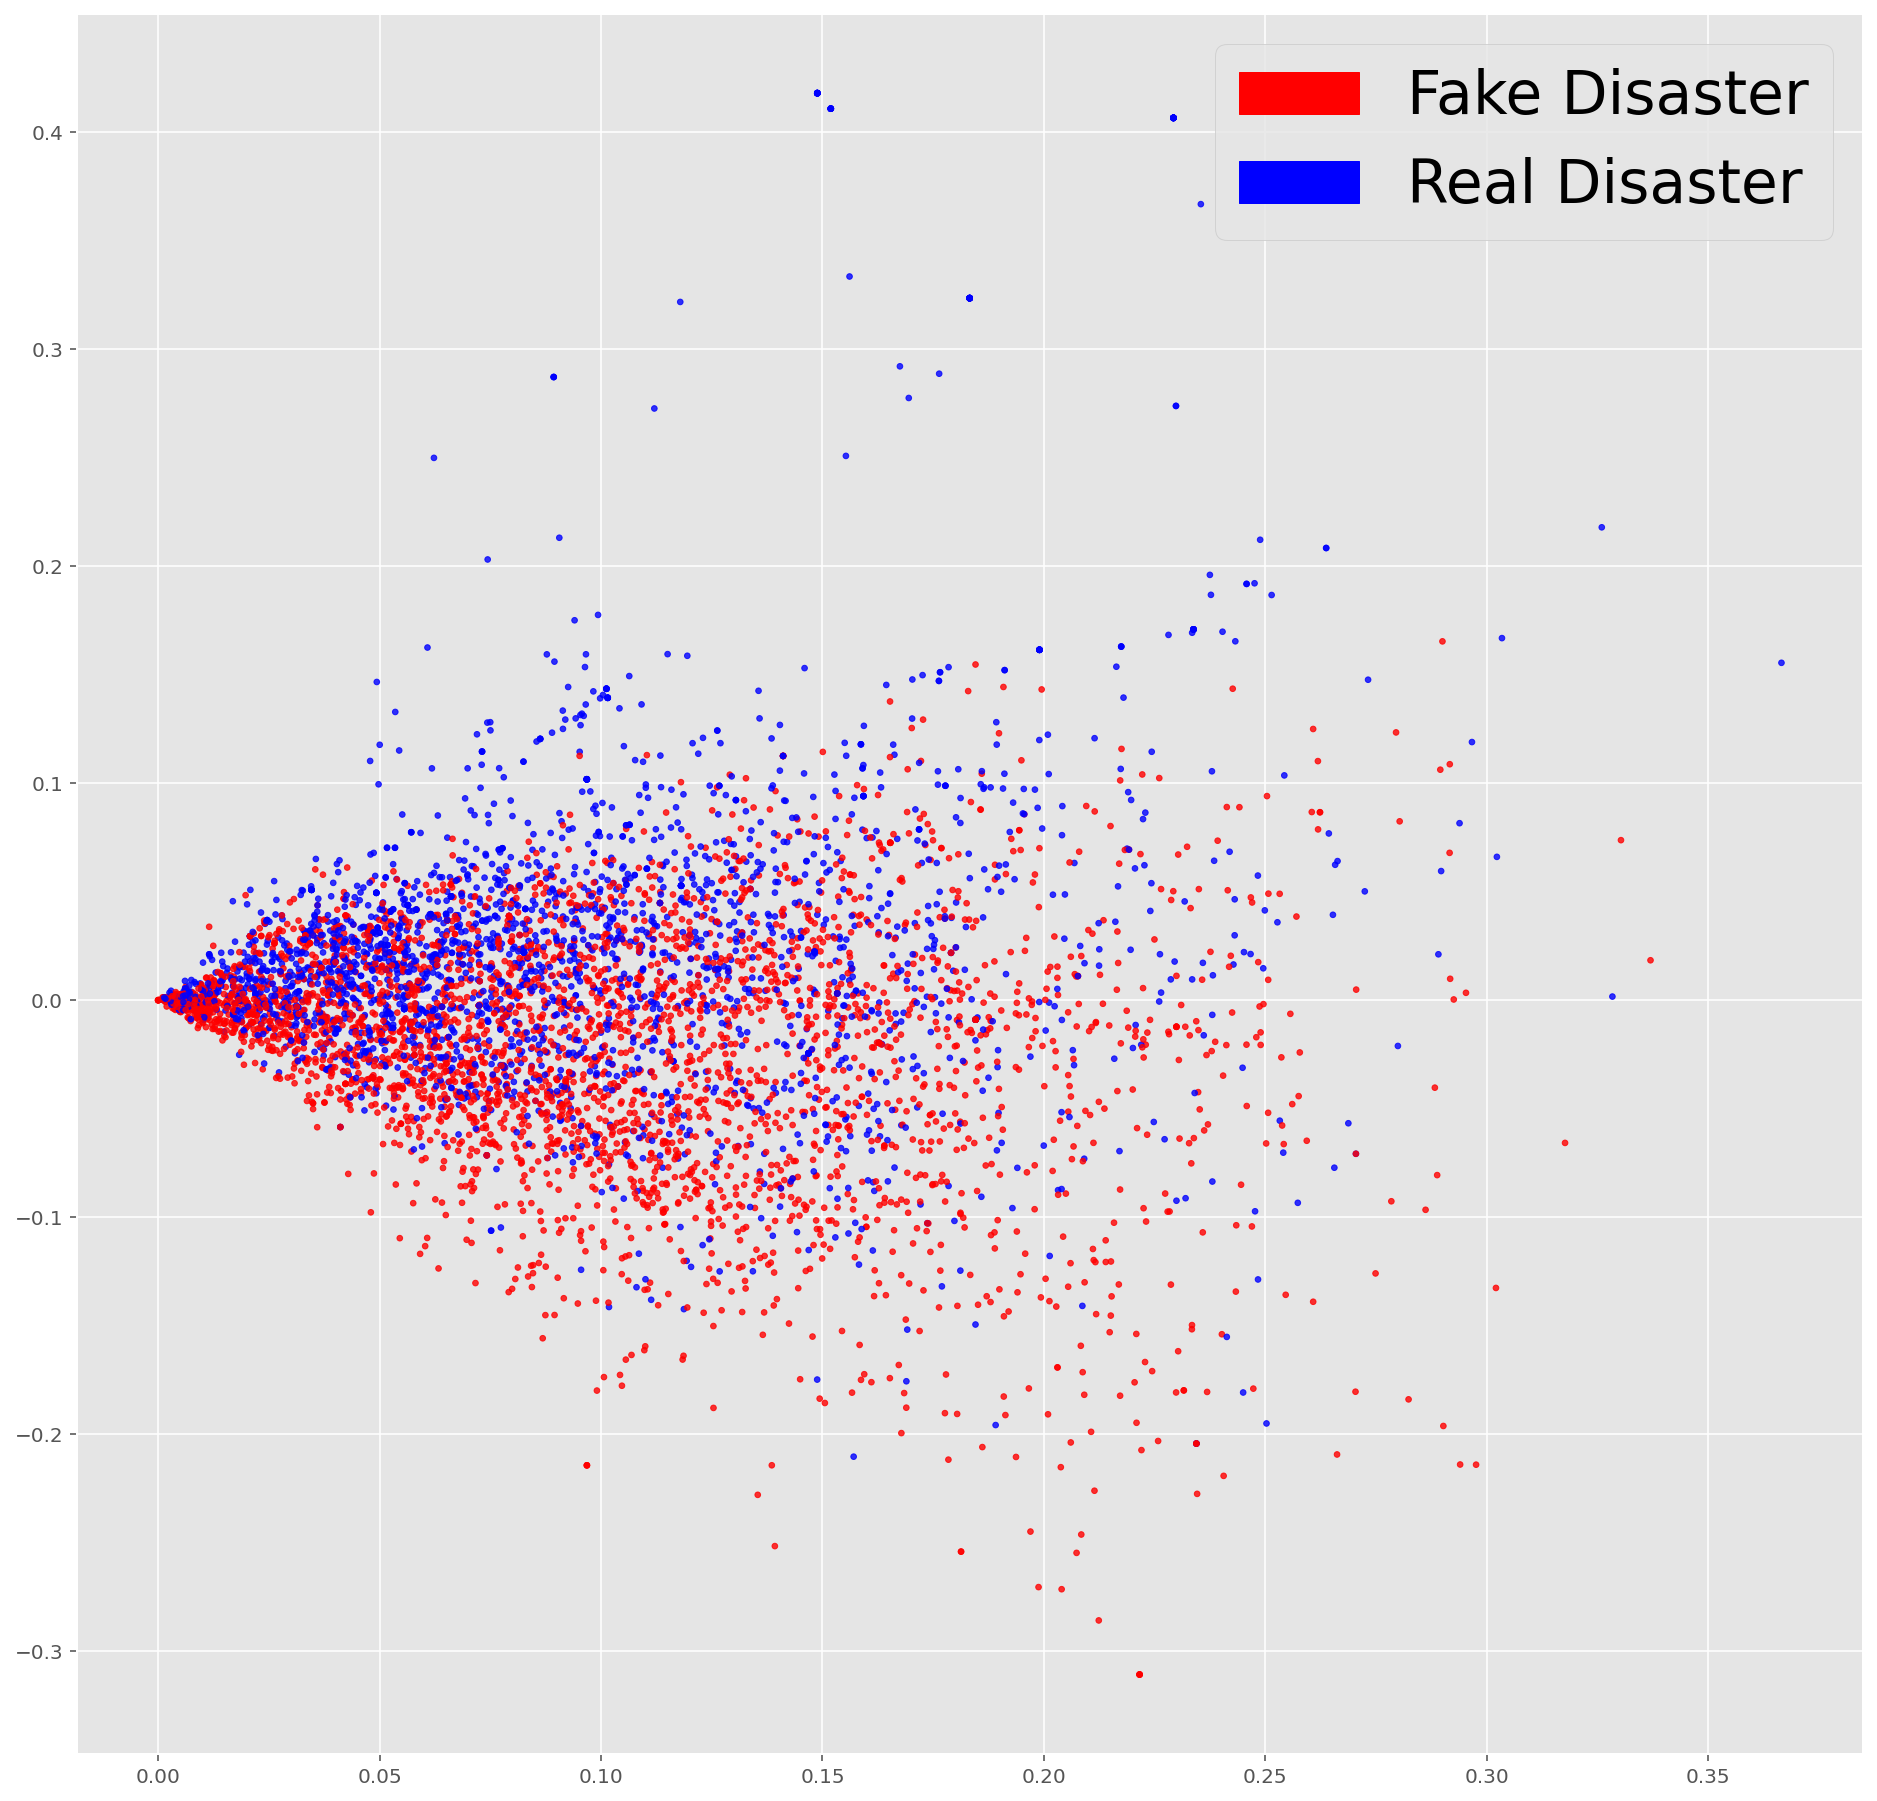

In [28]:
# Visualzie tfidf model with LSA
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [0]:
# Logistic Regression Model
model = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
# round the predicted value to int
train_pred_tfidf_int = y_pred.round().astype('int')

In [30]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.775, precision = 0.775, recall = 0.775, f1 = 0.775


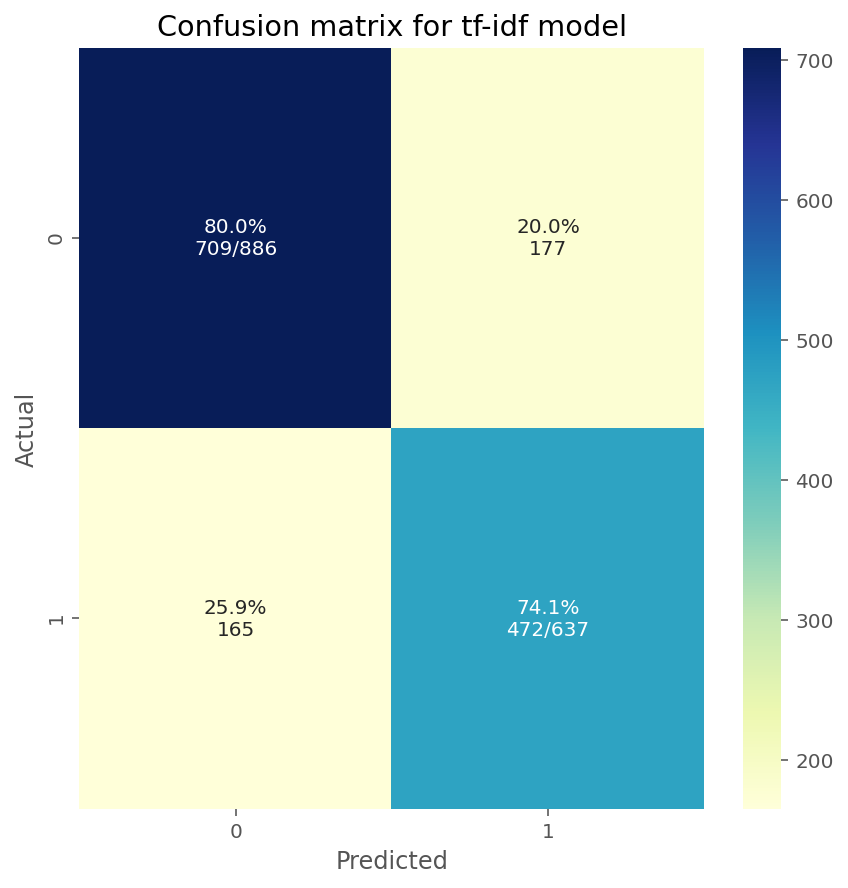

In [31]:
# Showing Confusion Matrix for tf-idf model
plot_cm(train_pred_tfidf_int, y_test, 'Confusion matrix for tf-idf model', figsize=(7,7))

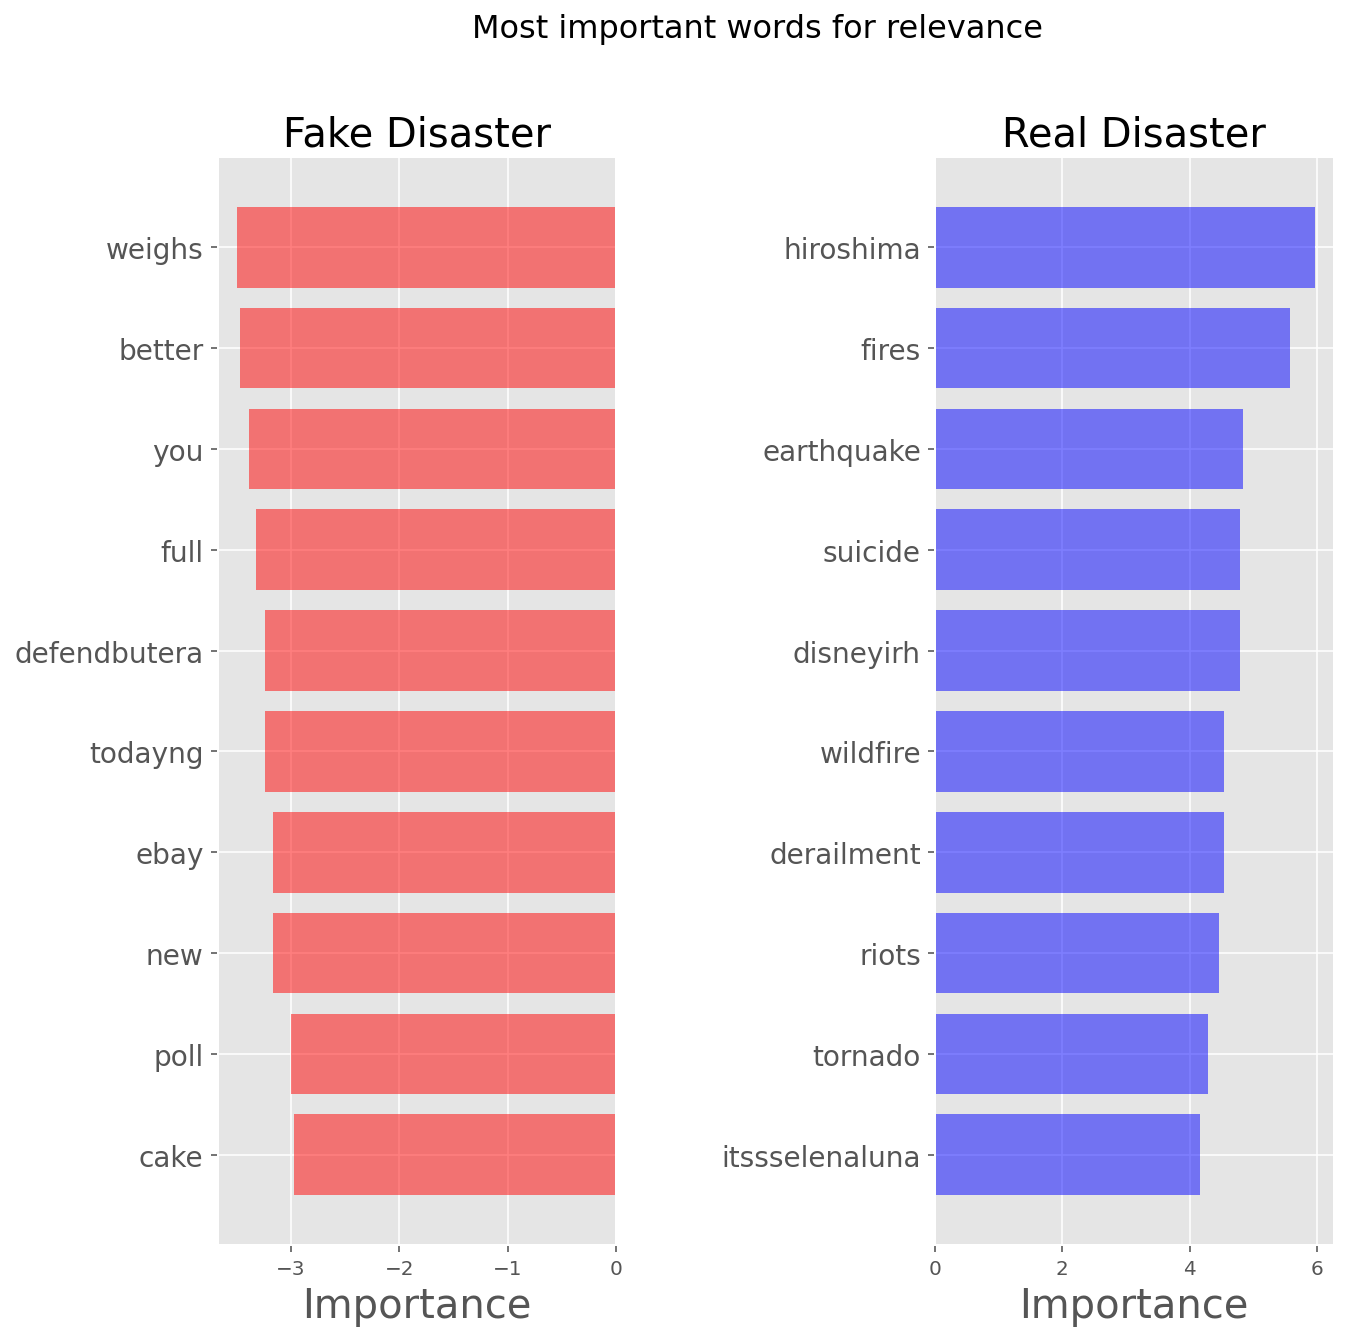

In [32]:
# important words based on the coefficients of Logistic Regression model
importance = get_most_important_features(tfidf_vectorizer, model, 10)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

The top words look very relevant to the context. The real-disaster picks upon words such as earthquake, fire, tornado etc.  

# Glove Model (Word2Vec)

In [33]:
# tokenize the corpus
nltk.download('punkt')
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus   
corpus=create_corpus_new(df)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


100%|██████████| 7613/7613 [00:00<00:00, 7872.85it/s]


In [0]:
# read the glove embedding and create a dict
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [0]:
# we have seen from the EDA that the max length available in the tweets is 35
MAX_LEN = 35
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [36]:
word_index=tokenizer_obj.word_index
num_words=len(word_index)+1

# defining the embedding matrix
embedding_matrix=np.zeros((num_words,100))
for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec  

100%|██████████| 18103/18103 [00:00<00:00, 612260.50it/s]


In [37]:
#train-test-val split
X_train, X_test, y_train, y_test = train_test_split(tweet_pad, tweet['target'].values, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)
print("Shape of test ",X_test.shape)

Shape of train (4567, 35)
Shape of Validation  (1523, 35)
Shape of test  (1523, 35)


In [0]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [39]:
history=model.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=(X_val,y_val),verbose=1)

Train on 4567 samples, validate on 1523 samples
Epoch 1/10
4567/4567 [==============================] - 13s 3ms/step - loss: 0.6219 - accuracy: 0.6534 - val_loss: 0.4939 - val_accuracy: 0.7735
Epoch 2/10
4567/4567 [==============================] - 11s 2ms/step - loss: 0.5277 - accuracy: 0.7554 - val_loss: 0.4696 - val_accuracy: 0.7938
Epoch 3/10
4567/4567 [==============================] - 11s 2ms/step - loss: 0.4998 - accuracy: 0.7721 - val_loss: 0.4655 - val_accuracy: 0.7984
Epoch 4/10
4567/4567 [==============================] - 11s 2ms/step - loss: 0.5024 - accuracy: 0.7666 - val_loss: 0.4573 - val_accuracy: 0.7984
Epoch 5/10
4567/4567 [==============================] - 11s 2ms/step - loss: 0.4943 - accuracy: 0.7810 - val_loss: 0.4621 - val_accuracy: 0.7991
Epoch 6/10
4567/4567 [==============================] - 11s 2ms/step - loss: 0.4906 - accuracy: 0.7797 - val_loss: 0.4521 - val_accuracy: 0.8030
Epoch 7/10
4567/4567 [==============================] - 11s 2ms/step - loss: 0.477

In [40]:
y_pred = model.predict(X_test).round().astype('int')
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.800, precision = 0.805, recall = 0.800, f1 = 0.795


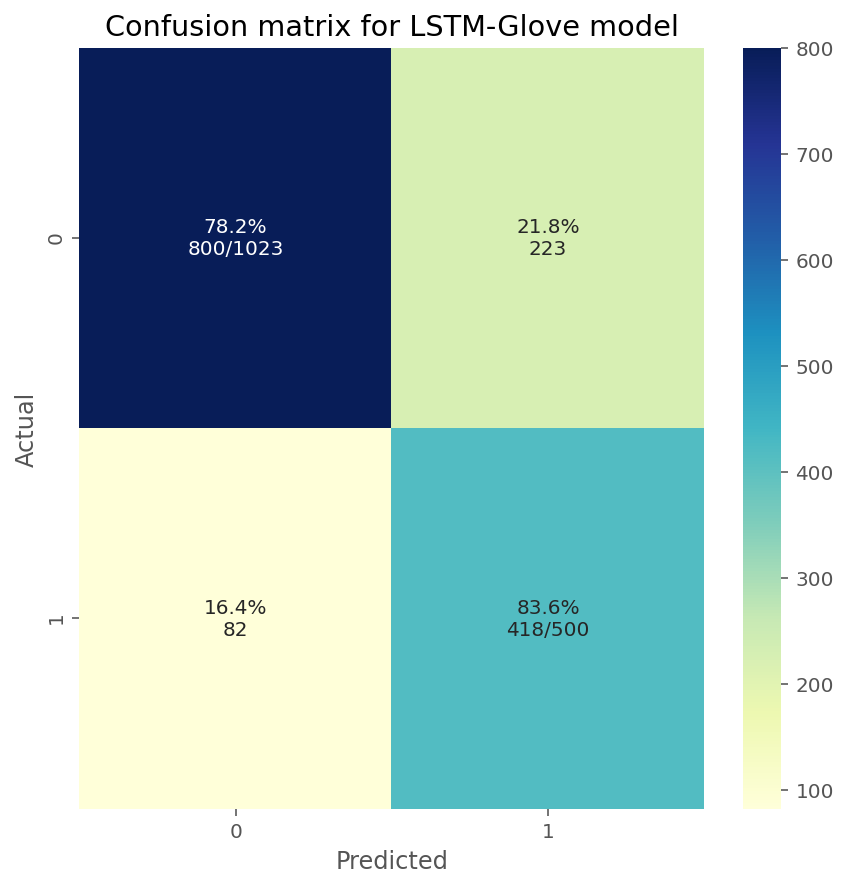

In [41]:
# Showing Confusion Matrix for LSTM model
plot_cm(y_pred, y_test, 'Confusion matrix for LSTM-Glove model', figsize=(7,7))

# BERT Model

In [0]:
# Ref: https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Google tokenizer
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
    

In [44]:
# Download bert
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 23.6 s, sys: 4.3 s, total: 27.9 s
Wall time: 32.6 s


In [70]:
train = df.sample(frac=0.8)
test = df[~df.isin(train)].dropna()
train.shape

(6090, 2)

In [0]:
#load tokenizer, vocab
import tokenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
#prepare the training data and encode data into tokens, masks and segment flags
train_input = bert_encode(train.text.values, tokenizer, max_len=50)
test_input = bert_encode(test.text.values, tokenizer, max_len=50)
train_labels = train.target.values

In [73]:
# Build the model
model = build_model(bert_layer, max_len=50)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]          

In [74]:
#train the model
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=5,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/5
305/305 [==============================] - 265s 869ms/step - loss: 0.2980 - accuracy: 0.8865 - val_loss: 0.2850 - val_accuracy: 0.9007
Epoch 2/5
305/305 [==============================] - 188s 616ms/step - loss: 0.1205 - accuracy: 0.9540 - val_loss: 0.3408 - val_accuracy: 0.8883
Epoch 3/5
305/305 [==============================] - 188s 615ms/step - loss: 0.0562 - accuracy: 0.9784 - val_loss: 0.3562 - val_accuracy: 0.8933
Epoch 4/5
305/305 [==============================] - 188s 616ms/step - loss: 0.0377 - accuracy: 0.9846 - val_loss: 0.4943 - val_accuracy: 0.8900
Epoch 5/5
305/305 [==============================] - 188s 616ms/step - loss: 0.0248 - accuracy: 0.9906 - val_loss: 0.5107 - val_accuracy: 0.8892


In [0]:
#prediction of test data
model.load_weights('model.h5')
test_pred = model.predict(test_input).round().astype('int')


In [77]:
#model evaluation
accuracy, precision, recall, f1 = get_metrics(test['target'],test_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.890, precision = 0.890, recall = 0.890, f1 = 0.890


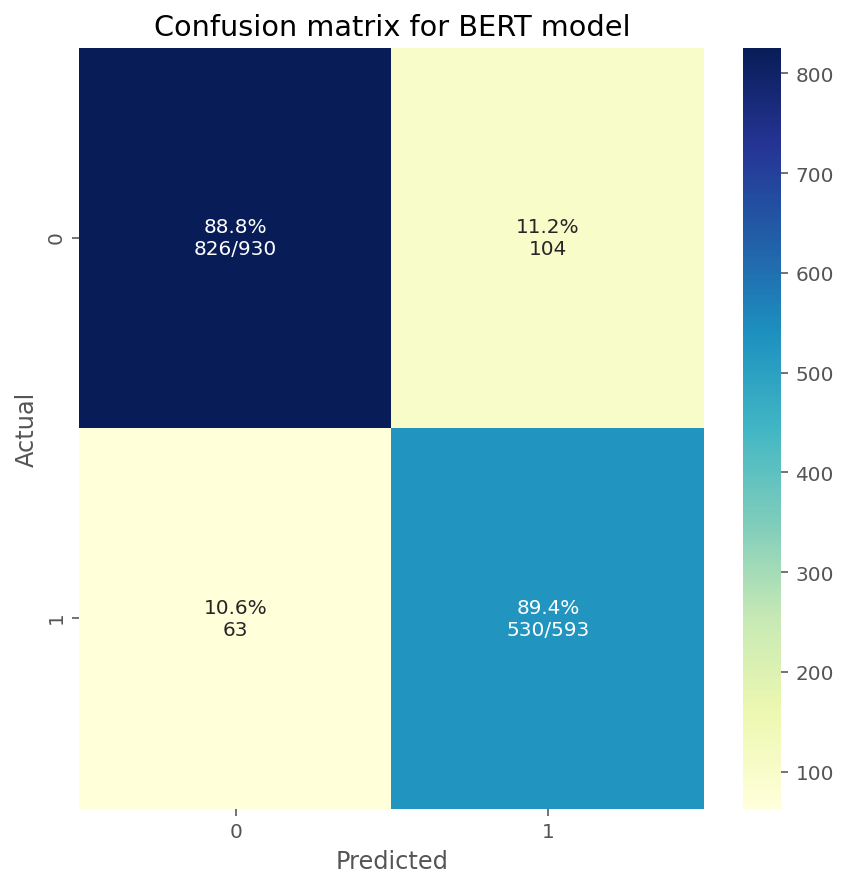

In [78]:
# Showing Confusion Matrix for bert model
plot_cm(test_pred, test['target'], 'Confusion matrix for BERT model', figsize=(7,7))